# Netflix Movie Recommendation using the Collaborative Filtering Approach


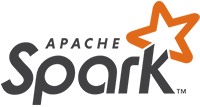

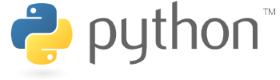



One of the most common uses of big data is to predict what users want. This allows Netflix to recommend movies that you might like. This lab will demonstrate how we can use Apache Spark to recommend movies to a user. We will start with some basic techniques, and then use the [Spark ML][sparkml] library's Alternating Least Squares method to make more sophisticated predictions.

In this project, we will use MLlib to make personalized movie recommendations . We will work with 3.2 million ratings from 1821 movies and 28978 users.



<div>
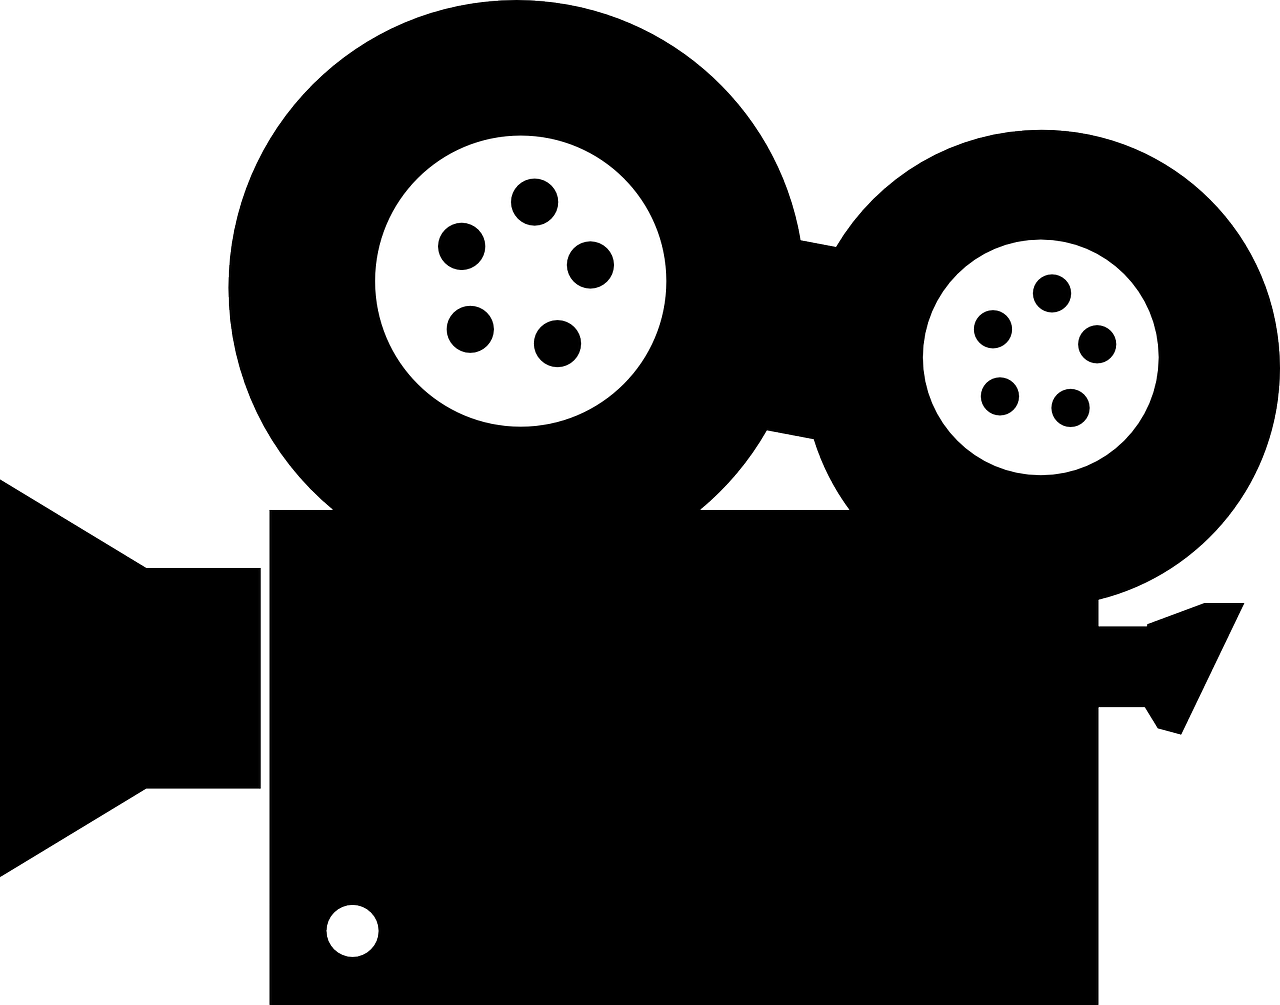
</div> 


You will need to Spawn a Spark cluster and Jupyter Notebook server using the instructions provided in Sparkify 8, and upload a copy of this notebook to this Spark Notebook server. Also, you will have to upload the dataset (i.e., txt files) on S3. The following cell defines the locations of the data files. You'll need to adjust the paths, below.

In [1]:
pip install --upgrade pandas

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: pandas in ./.local/lib/python3.7/site-packages (1.3.5)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

# Change to the location of data files
dbfs_dir = 's3://yashpreet.malhotra.cs79a.bucket'
movie_titles_filename = dbfs_dir + '/movie_titles.txt'
TrainingRatings_filename = dbfs_dir + '/TrainingRatings.txt'
TestingRatings_filename = dbfs_dir + '/TestingRatings.txt'

We're going to speed things up further by specifying the DataFrame schema explicitly. (When the Spark CSV adapter infers the schema from a txt file, it has to make an extra pass over the file. That'll slow things down here, and it isn't really necessary.)

In [3]:
from pyspark.sql.types import *

movie_titles_df_schema = StructType(
  [StructField('ID', IntegerType()),
   StructField('movie_year', IntegerType()),
   StructField('movie_title', StringType())]
)
TrainingRatings_df_schema = StructType(
  [StructField('movie_Id', IntegerType()),
   StructField('user_Id', IntegerType()),
   StructField('movie_ratings', FloatType())]
)
TestingRatings_df_schema = StructType(
  [StructField('movie_Id', IntegerType()),
   StructField('user_Id', IntegerType()),
   StructField('movie_ratings', FloatType())]
)

## Collaborative Filtering
In this course, you have learned about many of the basic transformations and actions that Spark allows us to apply to distributed datasets.  Spark also exposes some higher level functionality; in particular, Machine Learning using a component of Spark called [MLlib][mllib].  In this part, you will learn how to use MLlib to make personalized movie recommendations using the movie data we have been analyzing.

<img src="https://courses.edx.org/c4x/BerkeleyX/CS100.1x/asset/Collaborative_filtering.gif" alt="collaborative filtering" style="float: right"/>

We are going to use a technique called [collaborative filtering][collab]. Collaborative filtering is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue x than to have the opinion on x of a person chosen randomly. You can read more about collaborative filtering [here][collab2].

The image at the right (from [Wikipedia][collab]) shows an example of predicting of the user's rating using collaborative filtering. At first, people rate different items (like videos, images, games). After that, the system is making predictions about a user's rating for an item, which the user has not rated yet. These predictions are built upon the existing ratings of other users, who have similar ratings with the active user. For instance, in the image below the system has made a prediction, that the active user will not like the video.

<br clear="all"/>

----

# Load and Cache

By now, your datasets should be hosted on S3. We're going to be accessing this data a lot. Rather than read it over and over again from S3, we'll cache both the movies DataFrame and the ratings DataFrame in memory.

In [4]:
from pyspark.sql.functions import regexp_extract
from pyspark.sql.types import *

raw_movie_titles_df = sqlContext.read.format('csv').options(inferSchema=False).schema(movie_titles_df_schema).load(movie_titles_filename)
movie_titles_df= raw_movie_titles_df

raw_TrainingRatings_df = sqlContext.read.format('csv').options(inferSchema=False).schema(TrainingRatings_df_schema).load(TrainingRatings_filename)
TrainingRatings_df = raw_TrainingRatings_df

raw_TestingRatings_df = sqlContext.read.format('csv').options(inferSchema=False).schema(TestingRatings_df_schema).load(TestingRatings_filename)
TestingRatings_df = raw_TestingRatings_df

movie_titles_df.cache()
TrainingRatings_df.cache()
TestingRatings_df.cache()

assert movie_titles_df.is_cached
assert TrainingRatings_df.is_cached
assert TestingRatings_df.is_cached

raw_movie_titles_count = raw_movie_titles_df.count()
movie_titles_count = movie_titles_df.count()

raw_TrainingRatings_count = raw_TrainingRatings_df.count()
TrainingRatings_count = TrainingRatings_df.count()

raw_TestingRatings_count = raw_TestingRatings_df.count()
TestingRatings_count = TestingRatings_df.count()


print('There are %s movietitle, %s trainingRatings and %s testingRatings in the datasets' % (movie_titles_count, TrainingRatings_count,TestingRatings_count))
print('Movie_titles:')
movie_titles_df.show(3)
print ('TrainingRatings:')
TrainingRatings_df.show(3, truncate=False)
print ('TestingRatings:')
TestingRatings_df.show(3, truncate=False)

assert raw_movie_titles_count == movie_titles_count
assert raw_TrainingRatings_count == TrainingRatings_count
assert raw_TestingRatings_count == TestingRatings_count

There are 17770 movietitle, 3255352 trainingRatings and 100478 testingRatings in the datasets
Movie_titles:
+---+----------+--------------------+
| ID|movie_year|         movie_title|
+---+----------+--------------------+
|  1|      2003|     Dinosaur Planet|
|  2|      2004|Isle of Man TT 20...|
|  3|      1997|           Character|
+---+----------+--------------------+
only showing top 3 rows

TrainingRatings:
+--------+-------+-------------+
|movie_Id|user_Id|movie_ratings|
+--------+-------+-------------+
|8       |1744889|1.0          |
|8       |1395430|2.0          |
|8       |1205593|4.0          |
+--------+-------+-------------+
only showing top 3 rows

TestingRatings:
+--------+-------+-------------+
|movie_Id|user_Id|movie_ratings|
+--------+-------+-------------+
|8       |573364 |1.0          |
|8       |2149668|3.0          |
|8       |1089184|3.0          |
+--------+-------+-------------+
only showing top 3 rows



To get an idea on which similarity can be estimated more accurately, pick a user from the test set, extract the items this user has rated in the training set and compute how many other users in the training set have rated the same items. Let’s call this quantity overlap of an item for a given user. To get a comparison statistic you can average over all the items of that user and also perform this computation for multiple users from the test set to get an estimated average overlap of items forusers. Then do the same for items instead of users to get the estimated average overlap of users for items. Which number do you expect to be higher

In [5]:
AverageUser_df = TrainingRatings_df.filter("user_Id == 2149668")
AverageUser_df.show()


list1 = AverageUser_df.select('movie_Id')
array = [int(row.movie_Id) for row in list1.collect()]
users = TrainingRatings_df[TrainingRatings_df['movie_Id'].isin(array)]
users.show(10)

from pyspark.sql import functions as F
itemsusers = users.groupBy('user_Id').agg(F.count(users.movie_ratings).alias("count"),F.avg(users.movie_ratings).alias("average"))
print('movie_ids_with_avg_ratings_df:')
itemsusers.show(3, truncate=False)

+--------+-------+-------------+
|movie_Id|user_Id|movie_ratings|
+--------+-------+-------------+
|     992|2149668|          3.0|
|    1202|2149668|          3.0|
|    1289|2149668|          1.0|
|    1305|2149668|          3.0|
|    2015|2149668|          5.0|
|    2212|2149668|          3.0|
|    2342|2149668|          4.0|
|    2601|2149668|          3.0|
|    2675|2149668|          3.0|
|    2755|2149668|          3.0|
|    2913|2149668|          5.0|
|    2955|2149668|          5.0|
|    3151|2149668|          4.0|
|    3253|2149668|          4.0|
|    3274|2149668|          2.0|
|    3290|2149668|          5.0|
|    3355|2149668|          5.0|
|    3538|2149668|          4.0|
|    4847|2149668|          3.0|
|    4849|2149668|          3.0|
+--------+-------+-------------+
only showing top 20 rows

+--------+-------+-------------+
|movie_Id|user_Id|movie_ratings|
+--------+-------+-------------+
|     992| 306466|          3.0|
|     992| 765331|          4.0|
|     992|  41412

[Stage 25:=============================>                            (4 + 4) / 8]21/12/15 18:51:05 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


+-------+-----+------------------+
|user_Id|count|average           |
+-------+-----+------------------+
|128389 |42   |3.0238095238095237|
|2250628|25   |3.24              |
|279120 |24   |3.5416666666666665|
+-------+-----+------------------+
only showing top 3 rows



In [6]:
AverageUser_df = TrainingRatings_df.filter("movie_Id == 8")
AverageUser_df.show()

list1 = AverageUser_df.select('user_Id')
array = [int(row.user_Id) for row in list1.collect()]
users = TrainingRatings_df[TrainingRatings_df['user_Id'].isin(array)]
users.show(10)

from pyspark.sql import functions as F
itemsusers = users.groupBy('movie_Id').agg(F.count(users.movie_ratings).alias("count"),F.avg(users.movie_ratings).alias("average"))
print('movie_ids_with_avg_ratings_df:')
itemsusers.show(3, truncate=False)


+--------+-------+-------------+
|movie_Id|user_Id|movie_ratings|
+--------+-------+-------------+
|       8|1744889|          1.0|
|       8|1395430|          2.0|
|       8|1205593|          4.0|
|       8|1488844|          4.0|
|       8|1447354|          1.0|
|       8| 306466|          4.0|
|       8|1331154|          4.0|
|       8|1818178|          3.0|
|       8| 991725|          4.0|
|       8|1987434|          4.0|
|       8|1765381|          4.0|
|       8| 433803|          3.0|
|       8|1148143|          2.0|
|       8|1174811|          5.0|
|       8|1684516|          3.0|
|       8| 754781|          4.0|
|       8| 567025|          4.0|
|       8|1623132|          4.0|
|       8|1567095|          3.0|
|       8|1666394|          5.0|
+--------+-------+-------------+
only showing top 20 rows

+--------+-------+-------------+
|movie_Id|user_Id|movie_ratings|
+--------+-------+-------------+
|       8|1744889|          1.0|
|       8|1395430|          2.0|
|       8|1205593

In [7]:
trainingratings = TrainingRatings_df.toPandas()

#pd_testing = df_testing.toPandas()

In [8]:
#number of rated movies per user:
number_rated_movies = trainingratings.groupby("user_Id")["movie_ratings"].count().sort_values(ascending = False)
number_rated_movies.head()

user_Id
305344     1757
387418     1744
2439493    1640
1664010    1535
2118461    1481
Name: movie_ratings, dtype: int64

In [9]:
#number of rated movies per user:
rated_movies = trainingratings.groupby("movie_Id")["movie_ratings"].count().sort_values(ascending = False)
rated_movies.head()

movie_Id
6971    25468
6287    24393
4640    23525
9728    23184
8596    23005
Name: movie_ratings, dtype: int64

In [10]:
userItemRating = trainingratings.pivot_table(index='user_Id', columns='movie_Id', values='movie_ratings')
userItemRating.head()

movie_Id,8,28,43,48,61,64,66,92,96,111,...,17654,17660,17689,17693,17706,17725,17728,17734,17741,17742
user_Id,,,,,,,,,,,,,,,,,,,,,
7,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
userItemRating.fillna(0, inplace = True)
userItemRating.head()


movie_Id,8,28,43,48,61,64,66,92,96,111,...,17654,17660,17689,17693,17706,17725,17728,17734,17741,17742
user_Id,,,,,,,,,,,,,,,,,,,,,
7,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

In [13]:
Train= TrainingRatings_df.join(movie_titles_df,TrainingRatings_df.user_Id==movie_titles_df.ID)

test = TestingRatings_df.join(movie_titles_df,TestingRatings_df.user_Id==movie_titles_df.ID)

### Splitting the dataset

In [14]:
(split_60_df, split_a_20_df ) = TrainingRatings_df.randomSplit([7.5, 2.5])

# Let's cache these datasets for performance
train_df = split_60_df.cache()
validation_df = split_a_20_df.cache()

print('Training: {0}, validation: {1}\n'.format(
  train_df.count(), validation_df.count())
)
train_df.show(3)
validation_df.show(3)


[Stage 38:=============================>                            (4 + 4) / 8]

Training: 2439360, validation: 815992

+--------+-------+-------------+
|movie_Id|user_Id|movie_ratings|
+--------+-------+-------------+
|       8|      7|          5.0|
|       8|   1333|          3.0|
|       8|   3363|          2.0|
+--------+-------+-------------+
only showing top 3 rows

+--------+-------+-------------+
|movie_Id|user_Id|movie_ratings|
+--------+-------+-------------+
|       8|   3321|          1.0|
|       8|   7284|          5.0|
|       8|   9321|          3.0|
+--------+-------+-------------+
only showing top 3 rows



For movie recommendations, we start with a matrix whose entries are movie ratings by users (shown in red in the diagram below).  Each column represents a user (shown in green) and each row represents a particular movie (shown in blue).

Since not all users have rated all movies, we do not know all of the entries in this matrix, which is precisely why we need collaborative filtering.  For each user, we have ratings for only a subset of the movies.  With collaborative filtering, the idea is to approximate the ratings matrix by factorizing it as the product of two matrices: one that describes properties of each user (shown in green), and one that describes properties of each movie (shown in blue).

<img alt="factorization" src="http://spark-mooc.github.io/web-assets/images/matrix_factorization.png" style="width: 885px"/>
<br clear="all"/>

We want to select these two matrices such that the error for the users/movie pairs where we know the correct ratings is minimized.  The [Alternating Least Squares][als] algorithm does this by first randomly filling the users matrix with values and then optimizing the value of the movies such that the error is minimized.  Then, it holds the movies matrix constant and optimizes the value of the user's matrix.  This alternation between which matrix to optimize is the reason for the "alternating" in the name.

This optimization is what's being shown on the right in the image above.  Given a fixed set of user factors (i.e., values in the users matrix), we use the known ratings to find the best values for the movie factors using the optimization written at the bottom of the figure.  Then we "alternate" and pick the best user factors given fixed movie factors.

[als]: https://en.wikiversity.org/wiki/Least-Squares_Method
[mllib]: http://spark.apache.org/docs/latest/mllib-guide.html
[collab]: https://en.wikipedia.org/?title=Collaborative_filtering
[collab2]: http://recommender-systems.org/collaborative-filtering/

# ALS Approach

In this part, we will use the Apache Spark ML Pipeline implementation of Alternating Least Squares, ALS. ALS takes a training dataset (DataFrame) and several parameters that control the model creation process. To determine the best values for the parameters, we will use ALS to train several models, and then we will select the best model and use the parameters from that model in the rest of this lab exercise.

The process we will use for determining the best model is as follows:

1. Pick a set of model parameters. The most important parameter to model is the rank, which is the number of columns in the Users matrix (green in the diagram above) or the number of rows in the Movies matrix (blue in the diagram above). In general, a lower rank will mean higher error on the training dataset, but a high rank may lead to overfitting. We will train models with ranks of 4, 8, and 12 using the training_df dataset.

2. Set the appropriate parameters on the ALS object:

        - The "User" column will be set to the values in our userId DataFrame column.
        - The "Item" column will be set to the values in our movieId DataFrame column.
        - The "Rating" column will be set to the values in our rating DataFrame column.
        - We'll using a regularization parameter of 0.1.
Note: Read the documentation for the ALS class carefully. It will help you accomplish this step.

3. Have the ALS output transformation (i.e., the result of ALS.fit()) produce a new column called "prediction" that contains the predicted value.

4. Create multiple models using ALS.fit(), one for each of our rank values. We'll fit against the training data set (training_df).

5. For each model, we'll run a prediction against our validation data set (validation_df) and check the error.

6. We'll keep the model with the best error rate.


Why are we doing our own cross-validation?
A challenge for collaborative filtering is how to provide ratings to a new user (a user who has not provided any ratings at all). Some recommendation systems choose to provide new users with a set of default ratings (e.g., an average value across all ratings), while others choose to provide no ratings for new users. Spark's ALS algorithm yields a NaN (Not a Number) value when asked to provide a rating for a new user.

Using the ML Pipeline's CrossValidator with ALS is thus problematic, because cross validation involves dividing the training data into a set of folds (e.g., three sets) and then using those folds for testing and evaluating the parameters during the parameter grid search process. It is likely that some of the folds will contain users that are not in the other folds, and, as a result, ALS produces NaN values for those new users. When the CrossValidator uses the Evaluator (RMSE) to compute an error metric, the RMSE algorithm will return NaN. This will make all of the parameters in the parameter grid appear to be equally good (or bad).

In [15]:
als = ALS(maxIter=10, regParam=0.5, userCol="user_Id", 
                      itemCol = "movie_Id", ratingCol = "movie_ratings", coldStartStrategy = "drop")

model = als.fit(train_df)
#Generating Predictions
prediction = model.transform(validation_df)
evaluate1 = RegressionEvaluator(metricName="mse", labelCol="movie_ratings",
                                predictionCol="prediction")
                                            
evaluate2 = RegressionEvaluator(metricName="rmse", labelCol="movie_ratings",
                                predictionCol="prediction")



rmse = evaluate1.evaluate(prediction)
mse = evaluate2.evaluate(prediction)

print('The model had a MAE on the test set of {0}'.format(mse))
print('The model had a RMSE on the test set of {0}'.format(rmse))

[Stage 157:==============================================>      (174 + 8) / 200]

The model had a MAE on the test set of 1.0336890583191667
The model had a RMSE on the test set of 1.068513069288766


In [16]:
##TestData
predict_df = model.transform(TestingRatings_df)

# Remove NaN values from prediction (due to SPARK-14489)
predicted_test_df = predict_df.filter(predict_df.prediction != float('nan'))

# Run the previously created RMSE evaluator, reg_eval, on the predicted_test_df DataFrame
test_MAE = evaluate1.evaluate(predicted_test_df)
test_RMSE = evaluate2.evaluate(predicted_test_df)

print('The model had a MAE on the test set of {0}'.format(test_MAE))
print('The model had a RMSE on the test set of {0}'.format(test_RMSE))

[Stage 217:============================================>        (168 + 8) / 200]

The model had a MAE on the test set of 1.0741172384754827
The model had a RMSE on the test set of 1.0363962748270963


In [17]:
userRecommend = model.recommendForAllUsers(10)
movieRecommend = model.recommendForAllItems(10)
userRecommend.show()
movieRecommend.show()

+-------+--------------------+
|user_Id|     recommendations|
+-------+--------------------+
|    481|[[3033, 4.833468]...|
|   2678|[[3033, 3.6789656...|
|   3595|[[3033, 3.377369]...|
|   6460|[[3033, 3.994896]...|
|   7284|[[3033, 4.2301435...|
|   7576|[[3033, 4.207594]...|
|   9597|[[3033, 3.633531]...|
|  15191|[[3033, 4.096875]...|
|  15846|[[3033, 4.4358387...|
|  20461|[[3033, 3.6945784...|
|  20774|[[3033, 3.4982104...|
|  26258|[[3033, 3.945142]...|
|  27608|[[3033, 4.0977364...|
|  28346|[[3033, 3.7633572...|
|  30941|[[3033, 3.856298]...|
|  30976|[[3033, 4.1473007...|
|  31203|[[3033, 3.6661737...|
|  36822|[[3033, 4.1111326...|
|  40851|[[3033, 4.0672035...|
|  41068|[[3033, 3.1798801...|
+-------+--------------------+
only showing top 20 rows



[Stage 294:==================================================>   (93 + 7) / 100]

+--------+--------------------+
|movie_Id|     recommendations|
+--------+--------------------+
|     481|[[1482568, 3.8480...|
|    6911|[[1482568, 4.2477...|
|   11041|[[1482568, 3.9991...|
|   15841|[[1482568, 4.6041...|
|   15051|[[1482568, 4.6994...|
|    8851|[[1482568, 4.5978...|
|    1061|[[1482568, 4.3810...|
|   16283|[[1482568, 3.2875...|
|   12293|[[1482568, 5.5656...|
|   12273|[[1482568, 3.7682...|
|   12755|[[1482568, 4.9801...|
|   12705|[[1482568, 3.5804...|
|    2675|[[1482568, 3.1100...|
|    5465|[[1482568, 3.7763...|
|   10845|[[1482568, 3.7558...|
|    8825|[[1482568, 4.5972...|
|   13965|[[1482568, 3.8801...|
|    5025|[[1482568, 4.7460...|
|   11317|[[1482568, 3.9508...|
|    9517|[[1482568, 4.1833...|
+--------+--------------------+
only showing top 20 rows



### Adding myself as a User and rating movies:

In [18]:
from pyspark.sql import Row
my_user_id = 1

my_rated_movies = [
    (my_user_id, 12293,  3),
    (my_user_id, 10947,  5),
    (my_user_id, 2290,  2),
    (my_user_id, 14648,  3),
    (my_user_id, 14185,  5),
    (my_user_id, 11812,  5),
    (my_user_id, 11088,  4),
    (my_user_id, 25468,  4),
    (my_user_id, 5326,  4),
    (my_user_id, 3928,  2)
     # The format of each line is (my_user_id, movie ID, your rating)
     # For example, to give the movie "Star Wars: Episode IV - A New Hope (1977)" a five rating, you would add the following line:
     #   (my_user_id, 260, 5),
]

my_ratings_df = sqlContext.createDataFrame(my_rated_movies, ['user_Id','movie_Id','movie_ratings'])
print('My movie ratings:')
display(my_ratings_df.limit(10))
my_ratings_df.limit(10).show()


My movie ratings:


DataFrame[user_Id: bigint, movie_Id: bigint, movie_ratings: bigint]

+-------+--------+-------------+
|user_Id|movie_Id|movie_ratings|
+-------+--------+-------------+
|      1|   12293|            3|
|      1|    2290|            2|
|      1|   11812|            5|
|      1|   25468|            4|
|      1|   10947|            5|
|      1|   14648|            3|
|      1|   14185|            5|
|      1|   11088|            4|
|      1|    5326|            4|
|      1|    3928|            2|
+-------+--------+-------------+

